In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Missing Data & PCA


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

---

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

### Import Libraries

In [3]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**PART 1 [55 pts]: Predicting the selling price of used cars (missing data)**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Question 1: Visualizing Missing Data [10 pts]](#part1q1)
      - [Solutions](#part1q1solution)
  - [Question 2: Imputation Methods [45 pts]](#part1q2)
      - [Solutions](#part1q2solution)


- [**PART 2 [45 pts]: Principal Componant Analysis**](#part2)
  - [Question 3: PCA for Regression [35 pts]](#part2q3)
      - [Solutions](#part2q3solution)
  - [Question 4: Visualizing Transformed Data [10 pts]](#part2q4)
      - [Solutions](#part2q4solution)


<a id="part1"></a>
    
# PART 1 [55 pts]: Predicting the selling price of used cars (missing data)

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description 

[Return to contents](#contents)

In this part, we analyze the data about used cars from a [Kaggle project](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). The dataset is pre-processed and modified so that it contains missing values. The goal is to handle missing data and predict selling prices from the other features available in this dataset.

### Dataset 

The training dataset is available as `data/vehicle_dataset_train.csv`. It contains the following columns:

- `year` - year of the car when it was bought, 
- `mileage` - mileage of the car,
- `max_power` - maximum power of the engine (in bhps),
- `selling_price` - price at which the car is being sold (in lakh rupees)

The testing dataset is available as `data/vehicle_dataset_test.csv`. It contains all columns mentioned above.


### Objective

We will handle missing data and predict `selling_price` from the other features available in this dataset.

<a id="part1q1"></a>

## <div class='exercise'><b>Question 1: Visualizing Missing Data [10 pts]</b></div>

[Return to contents](#contents)

**PLEASE NOTE:** In this course, you will be expected to ALWAYS label your axes, title your graphs, and produce visuals which clearly communicate the data (as described in the [Instructions](#instructions) at the start of this notebook). Visuals should often be accompanied by text identifying the key point of the visual and defending any choices you make as a data scientist regarding the visual to best communicate your data.

In [4]:
# Load the datasets
df_train = pd.read_csv("data/vehicle_dataset_train.csv", index_col=0)
df_test = pd.read_csv("data/vehicle_dataset_test.csv", index_col=0)
df_train.head(5)

,year,mileage,max_power,selling_price
6601,2015,17.40,117.30,70.0
504,2017,13.60,NaN,262.5
5812,2018,24.00,73.97,71.0
1443,2009,19.70,46.30,15.0
7453,2014,16.02,NaN,42.5


In [5]:
# Separate predictors from responses
X_train, y_train = df_train.drop(columns=['selling_price']), df_train['selling_price']
X_test, y_test = df_test.drop(columns=['selling_price']), df_test['selling_price']

<div class='exercise-r'>

**Q1.1** Let's explore the extent of the missingness in the train data:

- store the number of rows with missing values in `n_rows_with_missingness`
- store the number of columns with missing values in `n_columns_with_missingness`
- Create a Pandas Series where the indices are the column names of `X_train` and the values are the number of missing data entries in the corresponding column in `X_train`. Store this series in `col_missingness`
</div> 

_Points:_ 4

In [6]:
n_rows_with_missingness = df_train.isna().sum(axis='index').sum()
n_cols_with_missingness = (df_train.isna().sum(axis='index') > 0).sum()
col_missingness = X_train.isna().sum(axis=0)

In [7]:
# display your results with this code
print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 44
# columns with missingness: 1

columns with missingness:
year          0
mileage       0
max_power    44
dtype: int64


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.2** Generate a boxplot of `year` for all samples that have missing values. In the same plot, generate another boxplot of `year` for all samples that do not have missing values. Do you see any pattern?  If so, what might be the implications of that pattern? 

</div> 

_Points:_ 6

It seems here that missing values for cars' maximum power tends to occur closer in the past (for more recent cars). For newer cars, 'max_power' sees irregularity in its reporting. This can be observed via the magnitude of the 'Year' attribute on the y-axis an the concentration of the 'True' observations in the higher levels. 
The hypothesis we are then able to formulate from a statistical perspective is that 'max_power' seems to be correlated with the 'Year' variable. This would essentially mean that it is probably missing at random. 

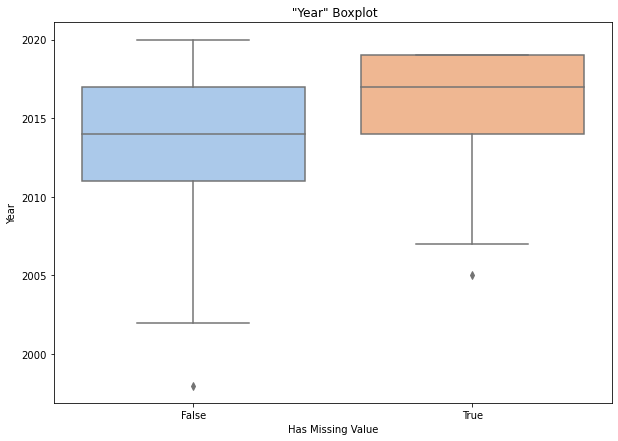

In [9]:
X_train_new = X_train.copy()
X_train_new['Has Missing Value'] = X_train_new['max_power'].isna()


plt.figure(figsize = (10,7))
sns.boxplot(data=X_train_new, x = 'Has Missing Value', y='year', palette = 'pastel')
plt.title(' "Year" Boxplot')
plt.ylabel('Year')
plt.show()

<!-- END QUESTION -->

<a id="part1q2"></a>

## <div class='exercise'><b> Question 2:   Imputation Methods [45 pts]</b></div>

[Return to contents](#contents)

We will try different ways of dealing with missing data. Take care not to overwrite the original `X_train` and `X_test` as we'll want to use them each time we try a new imputation method.

<div class='exercise-r'>

    

**2.1** First, we consider mean imputation:
  - Use SimpleImputer to impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**. 
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_meanimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_meanimp_r2` 
    
**NOTE:** For the sake of consistency, we will used standardized data throughout question 2 (consider why this is necessary for at least some of our models and imputation methods). Note that we are fitting our scaler on *all* the data (train + test).
    
</div>

_Points:_ 12

In [10]:
# Scaling and transforming the data:

scaler = StandardScaler().fit(pd.concat([X_train, X_test]))
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# impute into the train and test data
mean_imputer = SimpleImputer(strategy = "mean")
mean_imputed_train_data = mean_imputer.fit_transform(X_train_scaled)
mean_imputed_test_data = mean_imputer.transform(X_test_scaled)

# linear regression model
linear_regression = LinearRegression(fit_intercept=True)
linear_regression.fit(mean_imputed_train_data, y_train)

linreg_meanimp_r2 = linear_regression.score(mean_imputed_test_data, y_test)

# knn regression
knn_regression = KNeighborsRegressor(n_neighbors=2)
knn_regression.fit(mean_imputed_train_data, y_train)
knn_meanimp_r2 = knn_regression.score(mean_imputed_test_data, y_test)

In [11]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**2.2** Now, we will impute the data using k-NN regression model and see how it works:
  - Use KNNImputer ($k$=2) to impute both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_knnimp_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_knnimp_r2` 
</div>

_Points:_ 12

In [12]:
# Imputing into the train and test data

knn_imputer = KNNImputer(n_neighbors=2)
knn_imputed_train_data = knn_imputer.fit_transform(X_train_scaled)
knn_imputed_test_data = knn_imputer.transform(X_test_scaled)

# Linear Regression Model:
linear_regression = LinearRegression()
linear_regression.fit(knn_imputed_train_data, y_train)
linreg_knnimp_r2 = linear_regression.score(knn_imputed_test_data, y_test)

# knn regression
knn_regression = KNeighborsRegressor(n_neighbors=2)
knn_regression.fit(knn_imputed_train_data, y_train)
knn_knnimp_r2 = knn_regression.score(knn_imputed_test_data, y_test)

In [13]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

    
**2.3** Now, let's examine the indicator method:
  - For both the training and testing data, create an additional predictor called `has_missing_value` that indicates whether each row has any missing value.
  - Impute the mean of observed `max_power` values in the training dataset for both **X_train** and **X_test**.
  - Fit a linear regression model and store its $R^2$ score on the test data in `linreg_indic_r2`
  - Fit a k-NN regression model ($k$=2) store its $R^2$ score on the test data in `knn_indic_r2` 
    
</div>

_Points:_ 12

In [14]:
# Creating addditonal predictor that indicates whether each row has any missing value:

mean_imputed_train_data = pd.DataFrame(mean_imputed_train_data, columns=X_train.columns)
mean_imputed_test_data = pd.DataFrame(mean_imputed_test_data, columns=X_test.columns)

mean_imputed_train_data['has_missing_value'] = X_train['max_power'].isna().values
mean_imputed_test_data['has_missing_value'] = X_test['max_power'].isna().values

# Fitting linear regression model:
linear_regression = LinearRegression()
linear_regression.fit(mean_imputed_train_data, y_train)

linreg_indic_r2 = linear_regression.score(mean_imputed_test_data, y_test)

# Fitting KNN regression:
knn_regression = KNeighborsRegressor(n_neighbors=2)
knn_regression.fit(mean_imputed_train_data, y_train)

# Scoring KNN regression
knn_indic_r2 = knn_regression.score(mean_imputed_test_data, y_test)

In [15]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** Compare the $R^2$ values in **2.1** and **2.3**. Does adding an indicator variable help? Do these indicator method results provide any support **for** or **against** a claim that the data is missing completely at random? Why or why not?
    
</div>

_Points:_ 9

In [16]:
# Display your results
pd.DataFrame([
    {'missingness approach': 'mean imputation',
     'linreg test $R^2$': linreg_meanimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'knn imputation',
     'linreg test $R^2$': linreg_knnimp_r2,
     'knn test $R^2$': knn_knnimp_r2},
    {'missingness approach': 'missingness indicator + mean imputation',
     'linreg test $R^2$': linreg_indic_r2,
     'knn test $R^2$': knn_indic_r2}, 
]).set_index('missingness approach')

,linreg test $R^2$,knn test $R^2$
missingness approach,,
mean imputation,0.189,0.620
knn imputation,0.205,0.620
missingness indicator + mean imputation,0.395,0.652


Should data be missing at random, we know that adding a random indicator variable would not improve the model. 
However, it seems that in our case, comparing the R2 scores from with and without a random indicator variable for the KNN regression, adding this sort of variable has significantly increased the R2-score (0.620 --> 0.652). 
As a consequence of this, it is safe to assume that the data is not missing randomly. 

<!-- END QUESTION -->

<a id="part2"></a>
    
# PART 2 [45 pts]: Principal Component Analysis

[Return to contents](#contents)

<a id="part2q3"></a>

## <div class='exercise'><b> Question 3: PCA for Regression [35 pts]</b></div>

[Return to contents](#contents)
 

In this question, we will be using a dataset called "Communities and Crime" adapted from [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). The modified dataset contains 122 predictor variables and 1 response variable. All numeric data was normalized into the decimal range 0.00-1.00. Some of the predictor variables are:

- `householdsize`: mean people per household
- `medIncome`: median household income
- `PctHousOccup`: percent of housing occupied
- `RentMedian`: rental housing - median rent
- `PolicReqPerOffic`: total requests for police per police officer

And the response variable is 

- `ViolentCrimesPerPop`: total number of violent crimes per 100K popuation


In [17]:
# Load the datasets
df = pd.read_csv("data/communities_and_crime.csv", index_col = 0)
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,...,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,...,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.10,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.15,0.31,0.40,0.63,0.14,0.06,0.58,0.72,0.65,0.47,0.16,1.00,0.22,0.52,0.10,0.51,0.48,0.39,0.51,0.30,0.29,0.34,0.23,0.13,0.20,...,0.93,0.38,0.05,0.21,0.23,0.30,0.61,0.89,0.15,0.01,0.06,0.12,0.10,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.91,0.5,0.88,0.26,0.49
2,0.25,0.54,0.05,0.71,0.48,0.30,0.42,0.48,0.28,0.32,0.26,1.00,0.33,0.55,0.37,0.37,0.39,0.64,0.44,0.32,0.29,0.32,0.23,0.17,0.17,...,0.96,0.12,0.05,0.11,0.35,0.08,0.80,0.82,0.04,0.19,0.19,0.18,0.05,0.57,0.36,0.09,0.46,0.05,0.09,0.05,0.88,0.5,0.76,0.13,0.34
3,1.00,0.42,0.47,0.59,0.12,0.05,0.41,0.53,0.34,0.33,1.00,0.99,0.28,0.62,0.16,0.36,0.40,0.30,0.45,0.29,0.30,0.35,0.21,0.20,0.33,...,0.75,0.19,0.35,0.19,0.38,0.16,0.82,0.70,0.45,0.03,0.05,0.33,0.13,0.57,1.00,1.00,0.07,0.15,1.00,0.35,0.73,0.0,0.31,0.21,0.69
4,0.11,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,1.00,0.22,0.52,0.44,0.49,0.56,0.41,0.39,0.25,0.25,0.25,0.16,0.07,0.20,...,0.98,0.14,0.03,0.14,0.37,0.11,0.84,0.96,0.00,0.00,0.00,0.00,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


In [18]:
# Separate predictors and response
X, y = df.drop(columns=['ViolentCrimesPerPop']), df['ViolentCrimesPerPop']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="part2q3solution"></a>
## Question 3: Solutions 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Compute the correlation matrix for the predictor variables in the training data (DO NOT print the entire matrix). Which pairs of distinct predictor variables have correlation greater than 0.99 or less than -0.99? 
    
Store these pairs in a dictionary called `high_corr` where the keys are tuples corresponding to the names of the pair of predictors and the values are the correlation between each pair.
    
</div>

_Points:_ 6

In [19]:
# We create a list of the highest correlation pairs to which we will append them:
list_of_correlation_pairs = []

# Correlation matrix is given by:
correlation_matrix = df.corr()

# Iterating through columns and rows of correlation matrix:
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        
        # Computing the correlation between each column and row:
        correlation = correlation_matrix[col][row]
        
        # Selecting correlations that are greater than |0.99|:
        # - Having correlation greater than 0.99 and less than -0.99 is equivalent to having 
        #   an absolute value greater than 0.99
        # - We also want to make sure we are excluding correlation with oneself
        
        if np.abs(correlation) > 0.99 and col != row and (row, col) not in list_of_correlation_pairs:
            list_of_correlation_pairs.append((col, row))

high_corr = {k: correlation_matrix[k[0]][k[1]] for k in list_of_correlation_pairs}


print("The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.99 or less than -0.99:


{('population', 'numbUrban'): 0.9997729914101169,
 ('PctRecentImmig', 'PctRecImmig5'): 0.9931057924797181,
 ('PctRecImmig5', 'PctRecImmig8'): 0.9964586620664146,
 ('PctRecImmig5', 'PctRecImmig10'): 0.990833469506277,
 ('PctRecImmig8', 'PctRecImmig10'): 0.9969768983253605,
 ('OwnOccLowQuart', 'OwnOccMedVal'): 0.9926514749923352,
 ('RentMedian', 'MedRent'): 0.9935818674914801,
 ('LemasSwornFT', 'LemasSwFTFieldOps'): -0.9908274491163341,
 ('LemasSwFTPerPop', 'PolicPerPop'): 0.9999938757673811}

In [20]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Fit a linear regression model on the **unscaled** training data **using all available predictors**. Store the train and test $R^2$ scores in `linreg_train_r2` and `linreg_test_r2` respectively. Interpret your results.
    
</div>

_Points:_ 6

Very simply put, recall that $R^{2} = \frac{variance explained by model} {total variance}$.
This means that a test $R^{2}$ of roughly 0.22 means that the linear regression model is able to explain about 22% of the variance in our observations.  
Computing $R^{2}$ on the training data gives us 0.846, which means that approximately 84.6% of the variation within our sample is explained by the linear regression model.

In [21]:
# your code here

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
y_predictions_test = linear_regression.predict(X_test)
y_predictions_train = linear_regression.predict(X_train)

linreg_train_r2 = r2_score(y_train, y_predictions_train)
linreg_test_r2 = r2_score(y_test, y_predictions_test)

print(f"linear regression train R^2: {linreg_train_r2:.4f}")
print(f"linear regression test R^2: {linreg_test_r2:.4f}")

linear regression train R^2: 0.8461
linear regression test R^2: 0.2186


In [22]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>


**3.3.1** Standardize both **X_train** and **X_test**, *fitting the scaler on all the data*, and for each number of components $k$ in $k \in \{1,2,3,4,5,6,8,10,12,15,20\}$: 

  - Fit the PCA transformation with n_components = $k$ on the standardized **X_train**.
    
  - Apply the PCA transformation to the standardized **X_train**.
    
  - Use scikit-learn's cross_validate(...) to perform a 10-fold cross validation for a linear regression model on the transformed training data. 
    
  Plot the mean validation MSE for each $k$. Store the best $k$ based on the mean validation MSE as `best_k`.
    
</div>

_Points:_ 14

In [23]:
# We start by scaling our data:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [24]:
# Defining a list to store the validation errors:
validation_errors = []

# List with k components as described:
k_components = [1,2,3,4,5,6,8,10,12,15,20]

for k in k_components:
    
    # Instantiating PCA and fitting it on our scaled training data:
    pca = PCA(k).fit_transform(X_train_scaled)
    
    # Computing the MSE
    mse = cross_validate(linear_regression, pca, y_train, scoring='neg_mean_squared_error', cv=10)
    
    # Retrieving the validation MSE:
    validation_mse = - np.mean(mse['test_score'])
    
    # Retrieving our validation errors and appending them to the pre-defined list
    validation_errors.append(validation_mse)

# Index of the best k component
best_k_index = validation_errors.index(min(validation_errors))

# Using index to identify best k in list of component values
best_k = k_components[best_k_index]

print(f"The best k is {best_k}.")

The best k is 8.


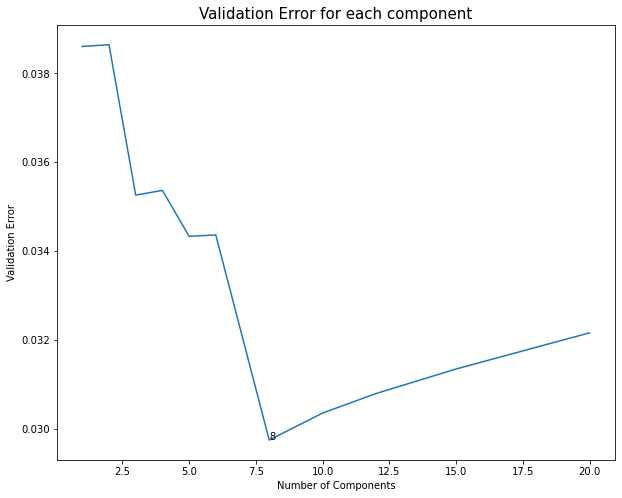

In [25]:
plt.figure(figsize = (10,8))
plt.plot(k_components, validation_errors)
plt.xlabel('Number of Components')
plt.ylabel('Validation Error')
plt.annotate(best_k, xy =(best_k, min(validation_errors)))
plt.title('Validation Error for each component', fontsize=15);

In [26]:
grader.check("q3.3.1")

q3.3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>
    

**3.3.2** Now let's compute the $R^2$ value on the testing data:
  - Fit the PCA transformation on the standardized **X_train** with n_components equal to the best $k$ above.
  - Apply the PCA transformation to the standardized **X_train** and the standardized **X_test**. 
  - Fit a linear regression model to the PCA-transformed components. Store the train and test $R^2$ scores in `pcr_train_r2` and `pcr_test_r2` respectively.
    
</div>

_Points:_ 6

In [27]:
# Only fit scaler on training data:
scaler = StandardScaler().fit(X_train)

# Transform both training and testing:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining our PCA using our best_k:
pca = PCA(8).fit(X_train_scaled)

# Transforming:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fitting linear regression:
linreg = LinearRegression().fit(X_train_pca,y_train)

# Issuing predictions:
y_test_predictions = linreg.predict(X_test_pca)
y_train_predictions = linreg.predict(X_train_pca)

# Scoring on training and testing data:
pcr_test_r2 = r2_score(y_test, y_test_predictions)
pcr_train_r2 = r2_score(y_train, y_train_predictions)

print(f"PCR train R^2: {pcr_train_r2:.4f}")
print(f"PCR test R^2: {pcr_test_r2:.4f}")

PCR train R^2: 0.6382
PCR test R^2: 0.6870


In [28]:
grader.check("q3.3.2")

q3.3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.4** Compare the $R^2$ value obtained from **3.2** (original predictors) and **3.3.2** (PCR). Provide an explanation for the observed difference in these results.
    
</div>

_Points:_ 3

In [29]:
# Display your results
pd.DataFrame([
    {'model': 'linear regression (original predictors)',
     'train $R^2$': linreg_train_r2,
     'test $R^2$': linreg_test_r2},
    {'model': f'PCR (k={best_k})',
     'train $R^2$': pcr_train_r2,
     'test $R^2$': pcr_test_r2},
]).set_index('model')

,train $R^2$,test $R^2$
model,,
linear regression (original predictors),0.846,0.219
PCR (k=8),0.638,0.687


The issue that PCA circumvents is multicollinearity (significant correlation between predictors). This issue was evidenced in 3.1, and provides an explanation regarding the low $R^{2}$ value for the regression in 3.2.

We obtain a $R^2$ value of 0.687 using PCA as opposed to 0.219 without. This suggests an improvement in our model's predictive capabilities by using PCA. However, our train $R^2$ decreases from 0.846 to 0.638. This is expected, and is a consequence of the reduction in multicollinearity. Essentially, what is important to note here is that our model with PCA was able to reduce the dimensionality while still keeping the signal of the data. 

<!-- END QUESTION -->

<a id="part2q4"></a>

## <div class='exercise'><b> Question 4: Visualizing Transformed Data [10 pts]</b></div>

[Return to contents](#contents)

In this question, we will be using a dataset called "Better Life Index" adapted from [Organisation for Economic Co-operation and Development](https://stats.oecd.org/). The modified dataset contains 24 numerical variables and 1 categorical variable. The categorical variable `Country` is the name of the country. Some of the numerical variables include:

- `Dwellings without basic facilities`
- `Housing expenditure`
- `Rooms per person`
- `Household net adjusted disposable income`
- `Household net financial wealth`
- ...

In [30]:
# Load and inspect the datasets
df = pd.read_csv("data/OECD_well-being.csv", index_col = 0)
print('df shape:', df.shape)
df.head()

df shape: (38, 25)


,Country,Dwellings without basic facilities,Housing expenditure,Rooms per person,Household net adjusted disposable income,Household net financial wealth,Labour market insecurity,Employment rate,Long-term unemployment rate,Personal earnings,Quality of support network,Educational attainment,Student skills,Years in education,Air pollution,Water quality,Stakeholder engagement for developing regulations,Voter turnout,Life expectancy,Self-reported health,Life satisfaction,Feeling safe walking alone at night,Homicide rate,Employees working very long hours,Time devoted to leisure and personal care
0,Australia,1.1,20,2.3,33417,57462,4.3,72,1.36,52063,94,80,502,21.2,5,92,2.7,91,82.5,85,7.3,63.6,1.0,13.20,14.35
1,Austria,1.0,21,1.6,32544,59574,2.7,72,1.94,48295,92,85,492,17.1,16,93,1.3,75,81.3,70,7.0,80.7,0.4,6.78,14.55
2,Belgium,2.3,21,2.2,29968,104084,4.8,62,3.98,49587,92,75,503,18.2,15,84,2.2,89,81.1,75,6.9,70.7,1.0,4.31,15.77
3,Canada,0.2,22,2.5,29850,85758,3.9,73,0.81,48403,93,91,523,16.7,7,91,3.0,68,81.5,88,7.3,80.9,1.4,3.73,14.41
4,Chile,9.4,18,1.9,16588,21409,8.1,62,2.02,28434,84,65,443,17.3,16,69,1.5,49,79.1,57,6.7,51.1,4.5,10.06,14.90


In [31]:
# Separate predictors and response
country, X = df['Country'], df.drop(columns='Country').values

<div class='exercise-r'>

**4.1** Standardize **X** and apply a PCA transformation with n_components = 2 to your standardized data. Save the transformed data as `X_transformed`.
    
</div>


_Points:_ 2

In [32]:
X_scaled = scaler.fit_transform(X)


X_transformed = PCA(2).fit_transform(X_scaled)

In [33]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Make a scatter plot for the transformed data, where the x-axis corresponds to the first principal component, and the y-axis corresponds to the second principal component. The plot should state the amount of variance explained by each component. 

Label each point by its corresponding country name. Do you observe any pattern in the scatter plot? Be specific and explain.
    
</div>

_Points:_ 6

Recall that developed countries in this case would be countries with a low first component (such as the United Kingdom, Finland and Germany). In this case, they are well grouped together in the South-West part of the plot, and contrast significantly with countries in the North-East, which are outliers with a high second principal component (e.g., South Africa). 
In this case, one may argue that this PCA is *successful* in the sense that it clearly evidences the different levels of development / quality of life among countries, which probably would have not been this obvious without this sort of analysis. 

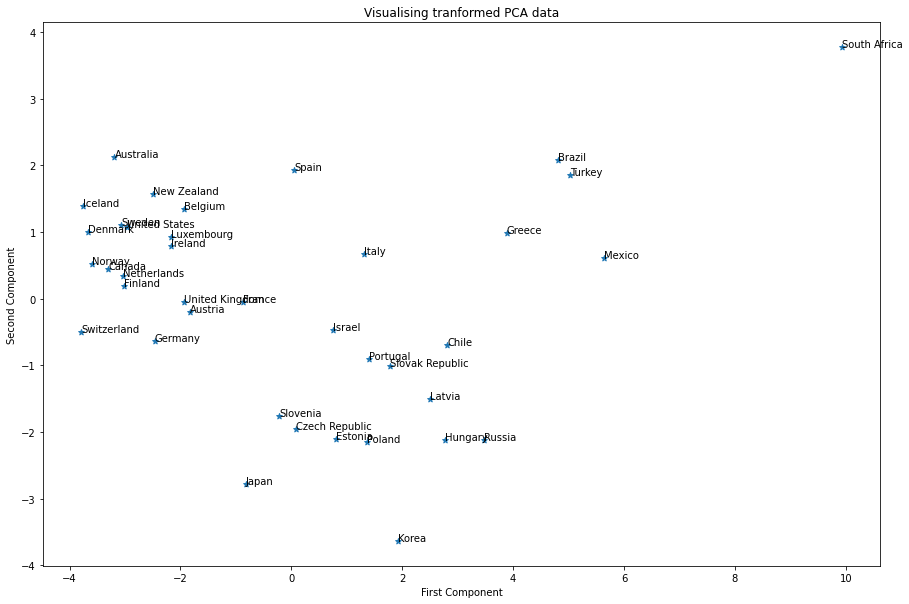

In [34]:
first_principal_comp = X_transformed[:,0]

second_principal_comp = X_transformed[:,1]


plt.figure(figsize=(15,10))
plt.scatter(first_principal_comp, second_principal_comp, marker = '*')
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.title("Visualising tranformed PCA data")

for c, txt in enumerate(country):
    plt.annotate(country[c], (X_transformed[:,0][c], X_transformed[:,1][c]),size=10)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** In question 3, where we also used PCA, we had a training and a test set. In question 4 we did not split the data. Explain why.
    
</div>

_Points:_ 2

A "learning" experiment occurs in 2 steps. First we fit a model in order to issue predictions regarding the response variable. We then report model performance using a set of metrics. This last part requires a part of the data which the model "hasn't see": the testing set (which will then tell us how well the model generalises).
In this case, we do not split the data because we are *not* conducting a "traditional" experiment: we are just visualising the data. 

<!-- END QUESTION -->

**This concludes HW4. Thank you!**

[Return to contents](#contents)